In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [2]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


## Figure S107

###  MIL-160

In [9]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/MIL-160/27C/hm/start_from_zero/'

filelist = os.listdir(path)
filelist = [i for i in filelist if i[-4:]=='.xls']

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File Heatmap_validation3-MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-28 21-51-17.xls read succesfull
File Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 00-43-02.xls read succesfull
File Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 04-08-05.xls read succesfull
File Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 08-17-06.xls read succesfull


Heatmap_validation3-MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-28 21-51-17.xls
Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 08-17-06.xls


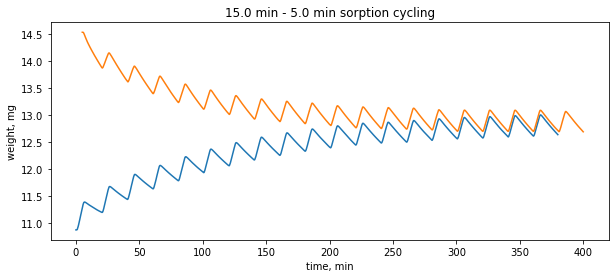

Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 00-43-02.xls
Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 04-08-05.xls


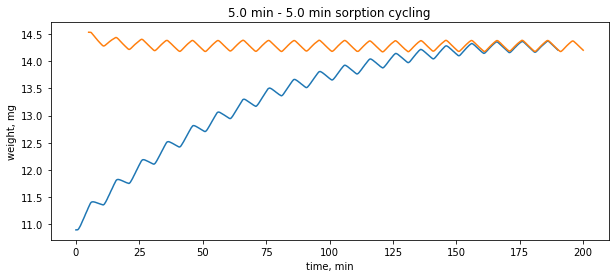

In [10]:
import numpy as np
import matplotlib as mpl

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=60)
Water_Sorption_list1 = [i for i in Water_Sorption_list if i.filename in ['Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 08-17-06.xls',
                                                                        'Heatmap_validation3-MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-28 21-51-17.xls',
                                                                        ]]
fig, ax1 = plt.subplots(figsize=(10, 4))
for m, Sorption in enumerate(Water_Sorption_list1 ):
    print(Sorption.filename)
    
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
    ax1.plot(Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'] - Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'].min() + m*(Sorption.data.iloc[split_index_des[1], :]['time']-Sorption.data.iloc[split_index_ads[0], :]['time'])
             ,
             Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['mass'], 
             #c='black',
             #label=Sorption.filename[-15:-4]
            )
    ax1.set_xlabel('time, min')
    ax1.set_ylabel('weight, mg')
    #ax2.set_ylabel('RH target, %', c='b')
    
    
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #              orientation='vertical', label='RH target, %')
    #plt.tight_layout()
    #ax1.set_ylim([10, 15])
#plt.legend()
split_index = Sorption.data.index[(Sorption.data['cycle_split']!=0)].to_list()
ax1.set_title('{0} min - {1} min sorption cycling'.format(
    round(Sorption.data.iloc[split_index[3], :]['time']-Sorption.data.iloc[split_index[2], :]['time'], 0),
    round(Sorption.data.iloc[split_index[2], :]['time']-Sorption.data.iloc[split_index[1], :]['time'], 0),
         ))
plt.savefig('Figure_hm_MIL-160two_1.png'.format(str(m)), dpi=300)
plt.show()
    



Water_Sorption_list2 = [i for i in Water_Sorption_list if i.filename in ['Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 00-43-02.xls',
                                                                        'Heatmap_validation_full_cycle_MIL-160_DJO-02-500_5-100um_HMvalidation-2021-12-27 04-08-05.xls',
                                                                        ]]
fig, ax1 = plt.subplots(figsize=(10, 4))
for m, Sorption in enumerate(Water_Sorption_list2 ):
    print(Sorption.filename)
    
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
    ax1.plot(Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'] - Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'].min() + m*(Sorption.data.iloc[split_index_des[1], :]['time']-Sorption.data.iloc[split_index_ads[0], :]['time'])
             ,
             Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['mass'], 
             #c='black',
             #label=Sorption.filename[-15:-4]
            )
    ax1.set_xlabel('time, min')
    ax1.set_ylabel('weight, mg')
    #ax2.set_ylabel('RH target, %', c='b')
    
    
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #              orientation='vertical', label='RH target, %')
    #plt.tight_layout()
    #ax1.set_ylim([10, 15])
#plt.legend()
split_index = Sorption.data.index[(Sorption.data['cycle_split']!=0)].to_list()
ax1.set_title('{0} min - {1} min sorption cycling'.format(
    round(Sorption.data.iloc[split_index[3], :]['time']-Sorption.data.iloc[split_index[2], :]['time'], 0),
    round(Sorption.data.iloc[split_index[2], :]['time']-Sorption.data.iloc[split_index[1], :]['time'], 0),
         ))
plt.savefig('Figure_hm_MIL-160two_2.png'.format(str(m)), dpi=300)
plt.show()

###  MOF-303

In [13]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/MOF-303/27C/hm/start_from_zero/'

filelist = os.listdir(path)
filelist = [i for i in filelist if i[-4:]=='.xls']

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File Heatmap_validation3-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-28 21-51-17.xls read succesfull
File Heatmap_validation_full_cycle_-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-27 08-17-06.xls read succesfull


Heatmap_validation3-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-28 21-51-17.xls
Heatmap_validation_full_cycle_-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-27 08-17-06.xls


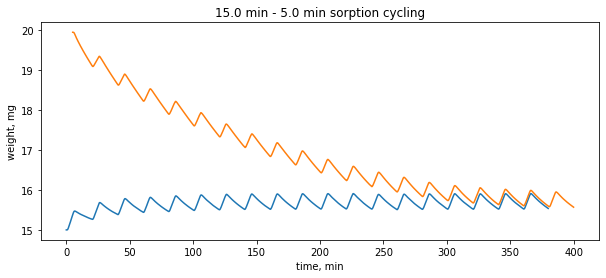

In [14]:
import numpy as np
import matplotlib as mpl

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=60)
Water_Sorption_list1 = [i for i in Water_Sorption_list if i.filename in ['Heatmap_validation_full_cycle_-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-27 08-17-06.xls',
                                                                        'Heatmap_validation3-MOF-303_SS-1131_5-100um_HMvalidation-2021-12-28 21-51-17.xls',
                                                                        ]]
fig, ax1 = plt.subplots(figsize=(10, 4))
for m, Sorption in enumerate(Water_Sorption_list1 ):
    print(Sorption.filename)
    
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
    ax1.plot(Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'] - Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['time'].min() + m*(Sorption.data.iloc[split_index_des[1], :]['time']-Sorption.data.iloc[split_index_ads[0], :]['time'])
             ,
             Sorption.data.iloc[min(split_index_ads[0], split_index_des[0]):, :]['mass'], 
             #c='black',
             #label=Sorption.filename[-15:-4]
            )
    ax1.set_xlabel('time, min')
    ax1.set_ylabel('weight, mg')
    #ax2.set_ylabel('RH target, %', c='b')
    
    
    #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #              orientation='vertical', label='RH target, %')
    #plt.tight_layout()
    #ax1.set_ylim([10, 15])
#plt.legend()
split_index = Sorption.data.index[(Sorption.data['cycle_split']!=0)].to_list()
ax1.set_title('{0} min - {1} min sorption cycling'.format(
    round(Sorption.data.iloc[split_index[3], :]['time']-Sorption.data.iloc[split_index[2], :]['time'], 0),
    round(Sorption.data.iloc[split_index[2], :]['time']-Sorption.data.iloc[split_index[1], :]['time'], 0),
         ))
plt.savefig('Figure_hm_MOF-303two_1.png'.format(str(m)), dpi=300)
plt.show()
